# Federated Learning Tutorial: Launching the Server


<img src="https://github.com/APPFL/APPFL/blob/main/docs/_static/logo/logo_small.png?raw=true" width="40%" alt="APPFL Logo">


In this tutorial, we will leverage the Advanced Privacy-Preserving Federated Learning ([APPFL](https://github.com/APPFL/APPFL)) framework to launch a federated learning server for orchestrating federated learning experiments between two distributed clients, whose client-launching code are available in your jupyter workspace as **Client1(APPFL_Client1_AIREADI.ipynb)** and **Client2(APPFL_Client2_AIREADI.ipynb)**, and you can also check it at: [client1](https://github.com/AdioosinUIUC/arvo-course/blob/main/APPFL_Client1_AIREADI.ipynb) and [client2](https://github.com/AdioosinUIUC/arvo-course/blob/main/APPFL_Client2_AIREADI.ipynb).

This example will train a simple ResNet using the AI-READI dataset partitioned into two client splits in a federated manner to predict the device of the collected images.

## 0. Introduction to Federated Learning

As shown in the figure below, federated learning can be understood as a distributed version of traditional machine by iterating the following two steps after a model initialization step

(1) Each client trains an ML model using its local dataset and submits the updated model to the server.

(2) The server aggregates these local models to update the global model and then sends it back to the clients for further local training.

As only model parameters are exchanged, federated learning offers a promising solution to utilize data from multiple data owners without direct data sharing, and it can usually help with training more robust, generalized, and powerful model by leveraging more training data.

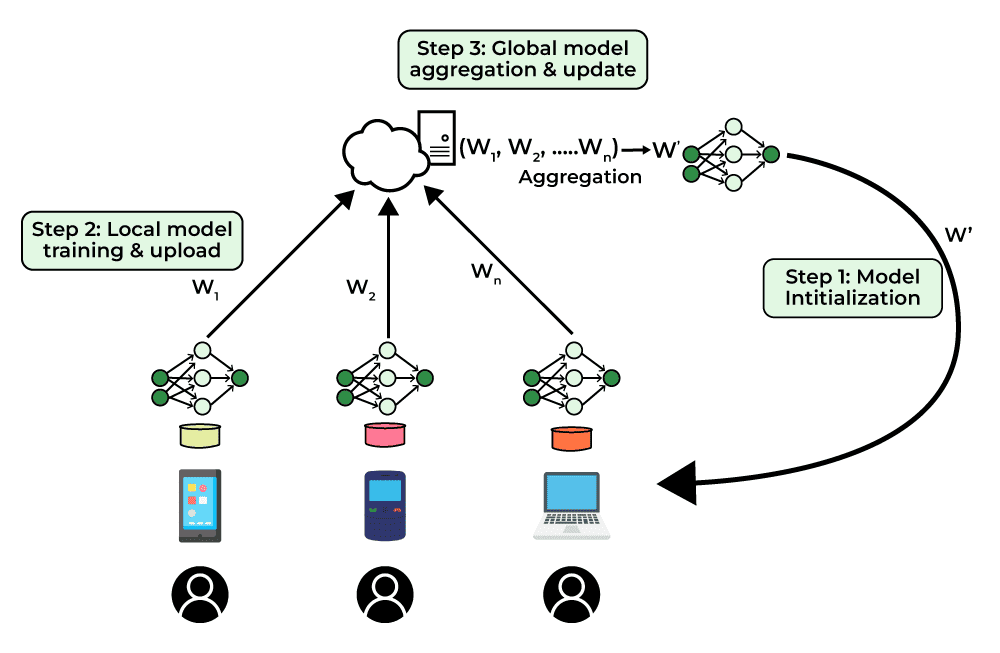

## 1. Install `appfl`

User needs to first install the `appfl` package by the following commands. Since we already have APPFL installed in our workspacewe will skip it.

`pip install appfl`

## 2. Set working directory

In [ ]:
import os
import warnings

warnings.filterwarnings('ignore')
# setting current working directory
target_directory = '/home/jupyter/lab/APPFL/examples'

os.chdir(target_directory)

## 3. Create federated learning server agent from configurations

Here we print the configurations needed to create a federated learning server. Specifically, it is composed of two main parts: `client_configs` and `server_configs`.

The `client_configs` mainly contains **general** configurations that should be the same among all cleints (e.g., training configurations, model architectures). Those configurations will be shared will all the clients at the beginning of experiments. This can avoid having each client to set the same configurations themselves separately. In this example, `client_configs` has two main components:

- `client_configs.train_configs`: This component contains configruations related to client's local training, such as the trainer to use, loss function, validation function, etc.

- `client_configs.model_configs`: This provides the path which defines the python function to load the architecture of the model to be trained.


The `server_configs` contains configurations that are specific to the federated learning server, such as the number of global epochs (total communication rounds between server and clients), and aggregators to use, etc.


 If you are interested, you can find more detailed explanations for the meanings of different configuration fields at [APPFL's official document](https://appfl.ai/en/latest/users/server_agent.html#configurations).

In [ ]:
from omegaconf import OmegaConf
from appfl.agent import ServerAgent

server_agent_config = OmegaConf.load("./resources/configs/aireadi/server_fedavg_ec2.yaml")
server_agent_config.client_configs.train_configs.train_batch_size = 64
server_agent_config.client_configs.train_configs.val_batch_size = 64
server_agent_config.client_configs.train_configs.num_workers = os.cpu_count()
print("==========Server Configuration==========")
print(OmegaConf.to_yaml(server_agent_config))
print("========================================")
server_agent = ServerAgent(server_agent_config=server_agent_config)


## 4. gRPC server communicator creation

In this step, we create a server communicator that facilitates communication between the server and its clients using gRPC. It provides a reliable medium for the server and clients to exchange information efficiently and asynchronously.

**The following code block will print out a link that you need to copy to your two client notebooks.**

In [ ]:
import socket
from appfl.comm.grpc import GRPCServerCommunicator

# Start the gRPC server communicator
communicator = GRPCServerCommunicator(
    server_agent,
    logger=server_agent.logger,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

# Getting the private IP address of the server
hostname = socket.gethostname()
private_ip = socket.gethostbyname(hostname)
print(f"\n\n✅ Replace server_uri with below in client notebook: {private_ip}:50051")

## 5. Launch the Server

Finally, you can use the communicator to start serving the FL server, which will handle different requests from the two clients to finish the FL experiments.

The client training results are logged in real time as a dictionary containing metrics such as `pre_val_accuracy` and `pre_val_loss` (accuracy and loss before each client's local training round) and `val_accuracy` and `val_loss` (accuracy and loss afterward). You will observe an increase in the model accuracy as the training proceeds.

In [ ]:
from appfl.comm.grpc import serve

serve(
    communicator,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)